# Network-based Spatial Information Theory Index 
## *from scratch*

What if you want to calculate the best segregation measure starting with no data?  
We've got you covered

In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import segregation
import matplotlib.pyplot as plt
from cenpy import products

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.6/site-packages/fuzzywuzzy-0.17.0-py3.6.egg/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<br>
First, we need to collect some data from the Census API. Using `cenpy`, we can grab all the necessary data in a single call. Let's store the variables we need in a list (these are total population counts from the 2017 ACS)  

<br>
    

In [2]:
black = 'B03002_004E'
white = 'B03002_003E'
hispanic = 'B03002_012E'
asian = 'B03002_006E'
variables = [white, black, hispanic, asian]

<br>
Using Atlanta as a test case, we'll grab the data and plot the non-hispanic Black population

In [3]:
atl = products.ACS(2017).from_msa(name='Atlanta, GA', variables=variables.copy(), level='tract')

Matched: Atlanta, GA to Atlanta-Sandy Springs-Roswell, GA within layer Metropolitan Statistical Areas


In [4]:
atl.head()

GEOID                                           geometry  \
0  13149970200  POLYGON ((-9494862.939999999 3952265.65, -9494...   
1  13143010302  POLYGON ((-9494734.369999999 3995852.68, -9494...   
2  13045910501  POLYGON ((-9480320.83 3974662.93, -9480146.5 3...   
3  13045910600  POLYGON ((-9474316.59 3979760.54, -9474224.859...   
4  13077170100  POLYGON ((-9463866.359999999 3951919.92, -9463...   

   B03002_003E  B03002_004E  B03002_012E  B03002_006E  \
0       4008.0        222.0         16.0          4.0   
1       7064.0        388.0        107.0        118.0   
2       3461.0       3703.0       1281.0         63.0   
3       3771.0       1431.0        669.0         76.0   
4       6133.0        653.0        502.0         71.0   

                                            NAME state county   tract  
0       Census Tract 9702, Heard County, Georgia    13    149  970200  
1  Census Tract 103.02, Haralson County, Georgia    13    143  010302  
2  Census Tract 9105.01, Carroll County, Georgia    13    045  910501  
3     Census Tract 9106, Carroll County, Georgia    13    045  910600  
4      Census Tract 1701, Coweta County, Georgia    13    077  170100

(-9516976.031000001, -9257699.189, 3862831.7115, 4123947.9185000006)

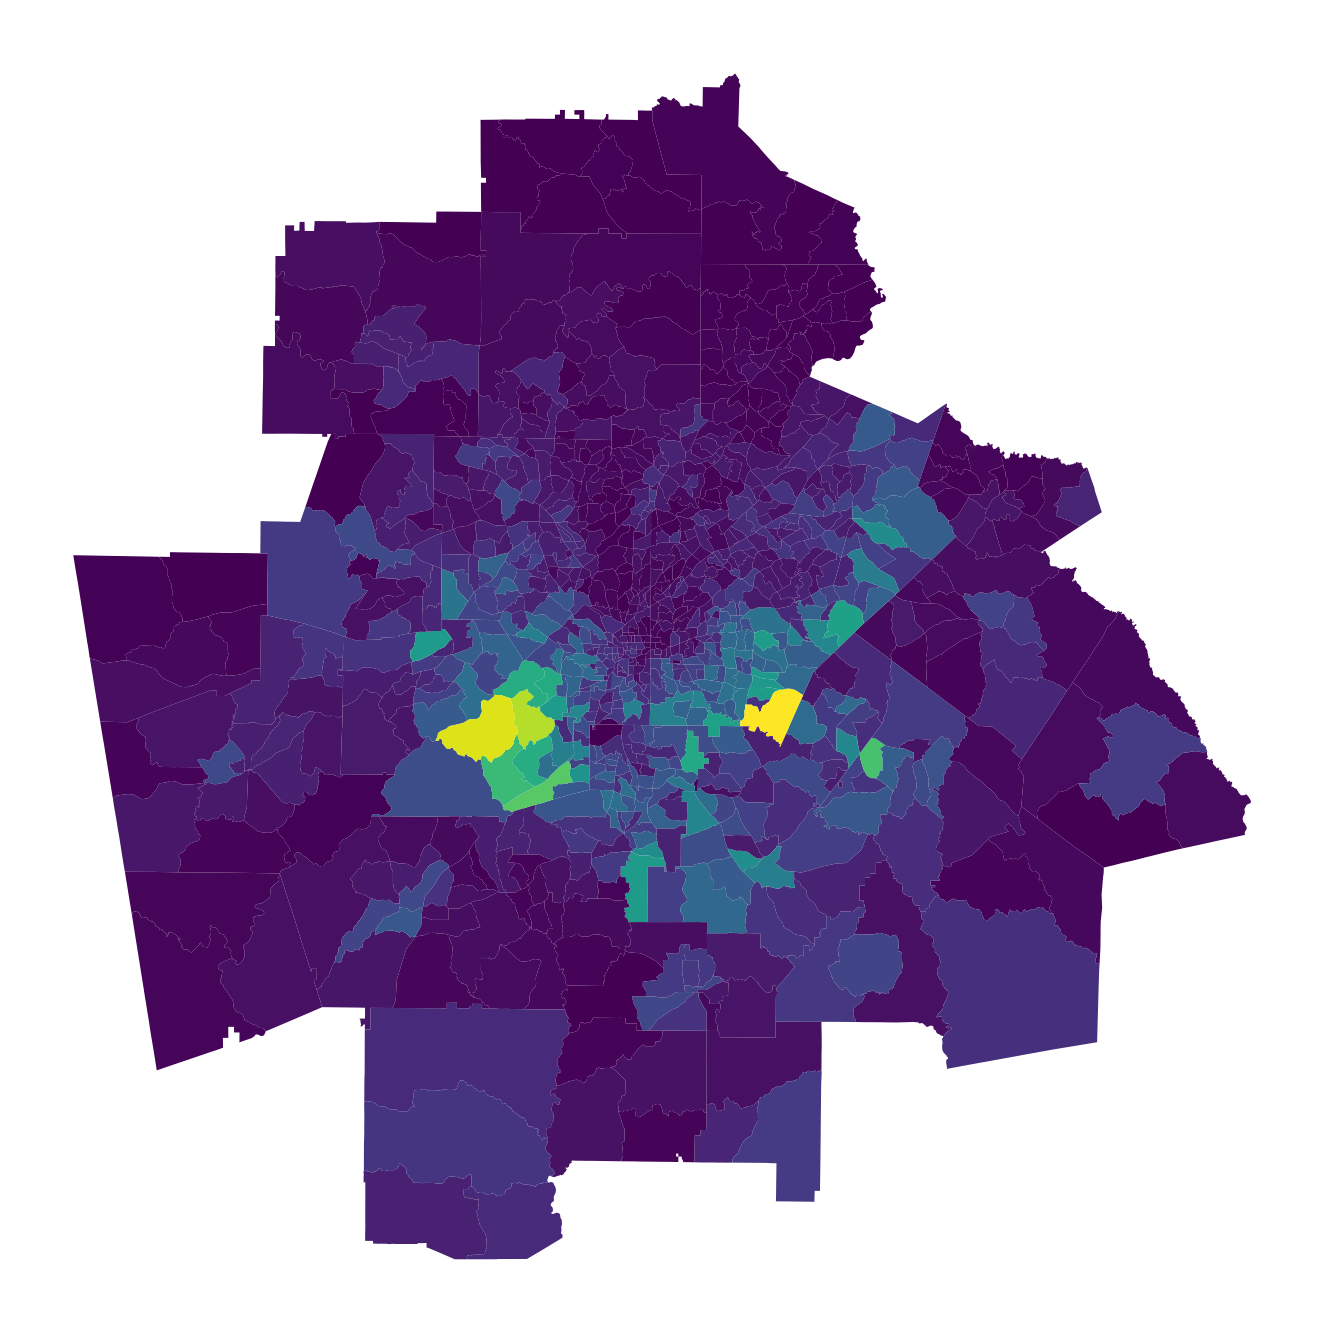

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
atl.plot(column='B03002_004E', ax=ax)
ax.axis('off')

In [6]:
atl = atl.to_crs({'init': 'epsg:4326'})

<br>
Now, we'll grab a walkable street network from OSM and use it to calculate our distance-decayed population sums. Under the hood we're using `pandana` and `urbanaccess` from the wonderful [UDST](http://www.urbansim.com/udst)

In [8]:
atl_network = segregation.network.get_network(atl)

Building network


downloading the network takes awhile, so uncomment to save it and you can load later

In [9]:
# balt_network.save_hdf5('atl_network.h5')

and use this to read it back in

In [7]:
import pandana as pdna
atl_network = pdna.Network.from_hdf5('atl_network.h5')

In [8]:
atl_access = segregation.network.calc_access(atl, network=atl_network, distance=5000, decay='exp', variables=variables)

In [9]:
atl_access.head()

acc_B03002_003E  acc_B03002_004E  acc_B03002_012E  acc_B03002_006E
id                                                                          
52373896              0.0              0.0              0.0              0.0
52373906              0.0              0.0              0.0              0.0
52373995              0.0              0.0              0.0              0.0
52374024              0.0              0.0              0.0              0.0
52374089              0.0              0.0              0.0              0.0

In [10]:
import geopandas as gpd
import contextily as ctx

<br>
Inside the accessibility calculation, pandana is snapping each tract centroid to its nearest intersection on the walk network. Then, it calculates the shortest path distance between every pair of intersrctions in the network and sums up the total population for each group accessible within the specified threshold, while applying a distance decay function to discount further distances

<br>
That means population access is measured for *each intersection* in the network. In essence, we're modeling down from the tract level to the intersection level. We can quickly convert the network intersections to a geopandas GeoDataFrame to plot and compare with the original tracts

In [11]:
net_points =gpd.GeoDataFrame(atl_access, geometry=gpd.points_from_xy(atl_network.nodes_df['x'],atl_network.nodes_df['y']))

In [12]:
net_points.crs = {'init': 'epsg:4326'}

In [13]:
import seaborn as sns
sns.set_context('notebook')

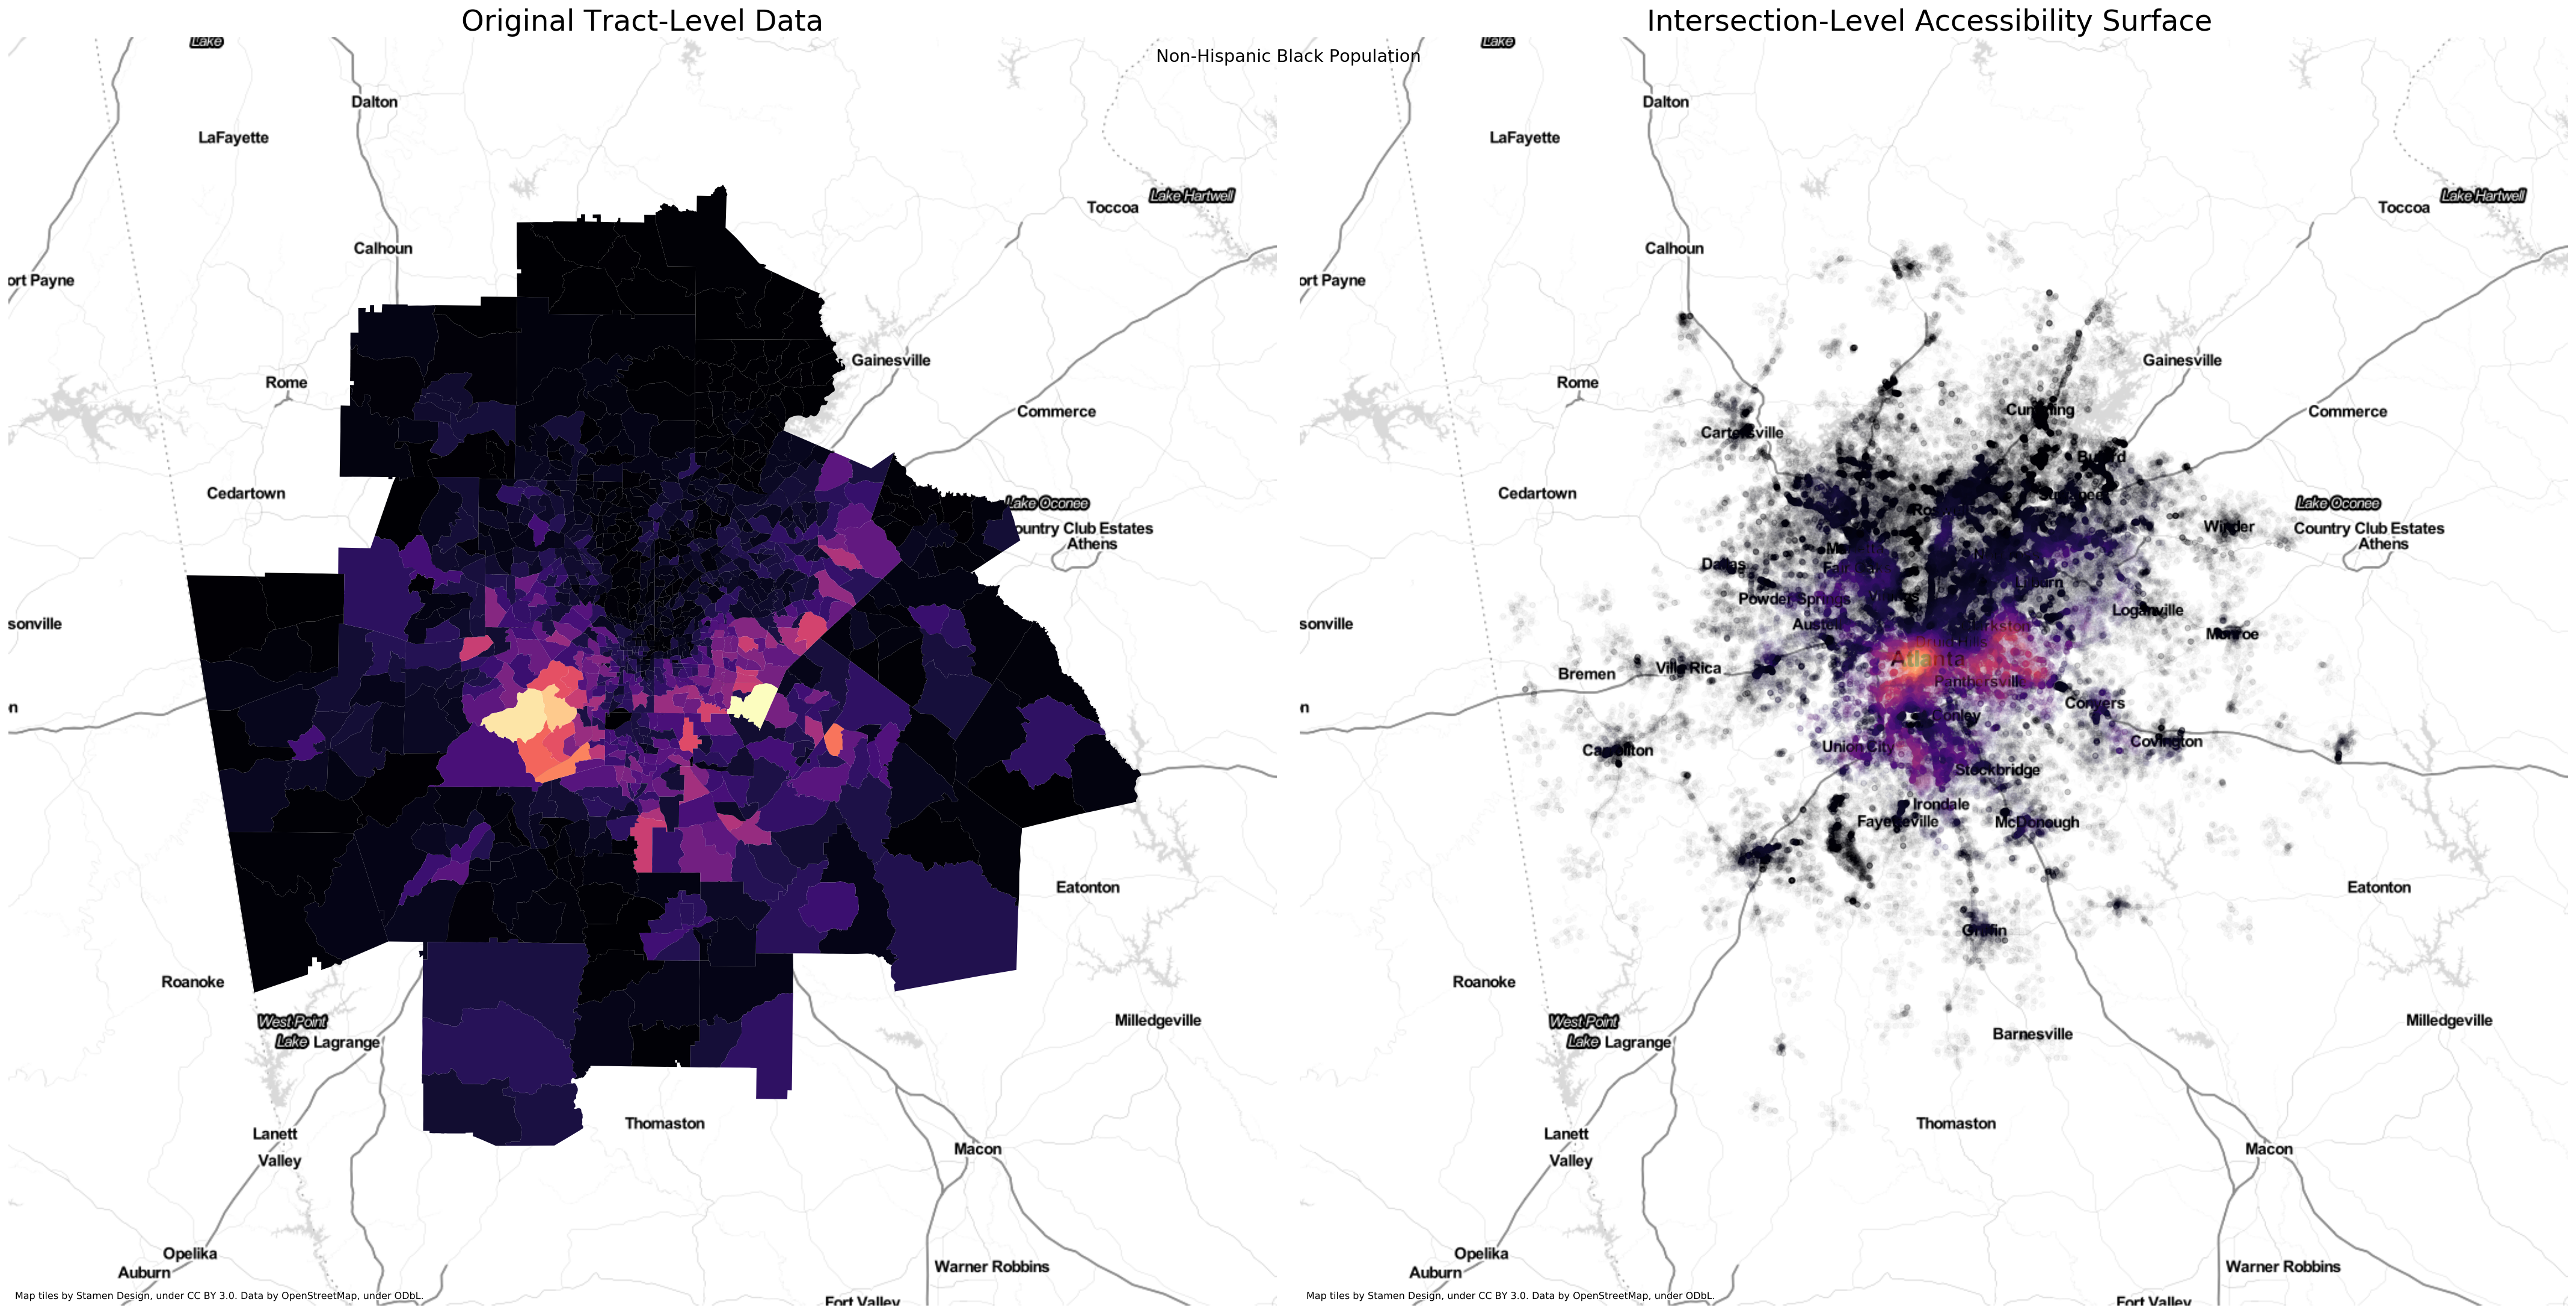

In [14]:
fig, ax = plt.subplots(1,2,figsize=(30,15))


# tracts
atl.to_crs({'init': 'epsg:3857'}).plot('B03002_004E', ax=ax[0], cmap='magma')
ctx.add_basemap(ax[0],url=ctx.sources.ST_TONER_LITE)
ax[0].axis('off')
ax[0].set_title('Original Tract-Level Data',fontsize=24)

# network
net_points[net_points.acc_B03002_004E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_004E', alpha=0.01, ax=ax[1], cmap='magma', s=20)
ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[1].axis('off')
ax[1].set_title('Intersection-Level Accessibility Surface ', fontsize=24)

plt.suptitle('Non-Hispanic Black Population')
plt.tight_layout()



The main advantage of the plot on the right
is that we avoid the visual distortion created by the large but sparsely populated tracts on the periphery and between the highways. It's a much better representation of metropolitan Atlanta's spatial structure. We use this version to compute the spatial information theory index.<br>   

  
Apart from the fact that we're now constraining the visualization to only the developed land, using transparency gives a further sense of the metro's development intensity, since denser areas appear more saturated. The hues have shifted in space slightly (e.g. the the brightest locus has shifted from the southwest in the left map toward the center in the right map) since they now represent distance-weighted densities, rather than totals.

Text(0.5, 1, 'Asian Accessibility Surface ')

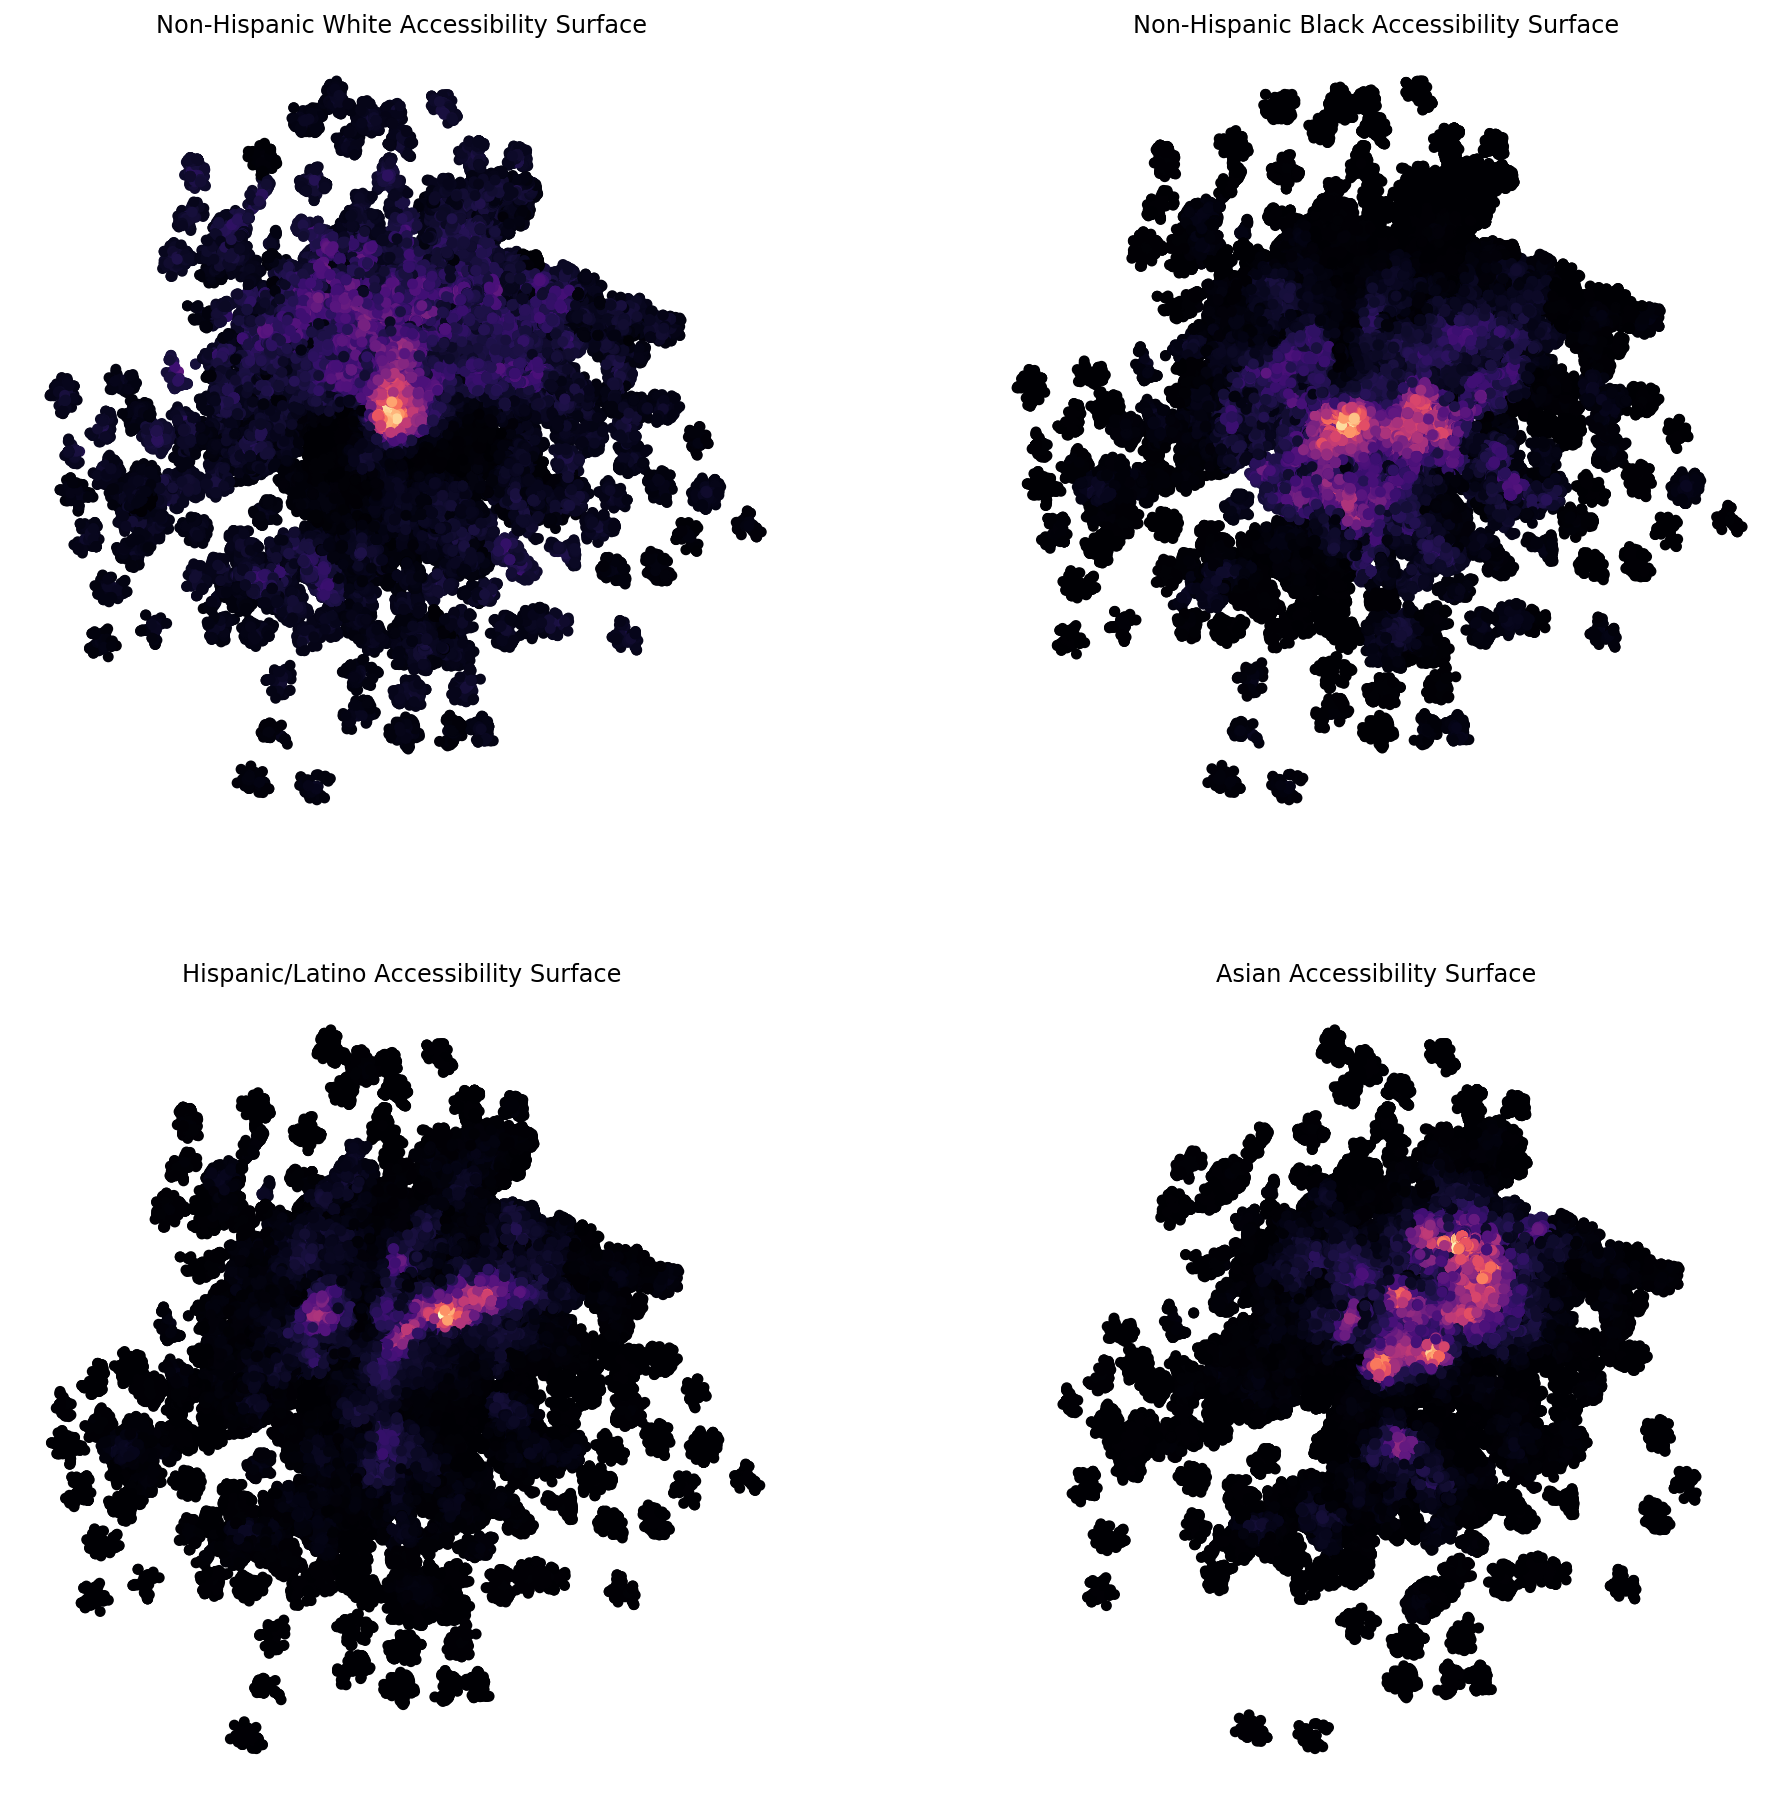

In [15]:
fig, ax = plt.subplots(2,2, figsize=(16,16))
ax = ax.flatten()


net_points[net_points.acc_B03002_003E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_003E', ax=ax[0], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[0].axis('off')
ax[0].set_title('Non-Hispanic White Accessibility Surface ')

net_points[net_points.acc_B03002_004E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_004E', ax=ax[1], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[1].axis('off')
ax[1].set_title('Non-Hispanic Black Accessibility Surface ')

net_points[net_points.acc_B03002_012E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_012E', ax=ax[2], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[2].axis('off')
ax[2].set_title('Hispanic/Latino Accessibility Surface ')

net_points[net_points.acc_B03002_006E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_006E', ax=ax[3], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[3].axis('off')
ax[3].set_title('Asian Accessibility Surface ')

Now we can use these surfaces to calculate the multi-group network-based spatial information theory index

In [16]:
from segregation.network import nbsit

In [17]:
nbsit(atl, variables)

/Users/knaaptime/projects/segregation/segregation/network/network.py:145: RuntimeWarning: divide by zero encountered in log
  Ep = -(pi_pm * np.log(pi_pm) / np.log(m)).sum(axis=1)


0.2856858192363312